### Импорт и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import kurtosis, skew
from scipy.fftpack import fft
from sklearn.decomposition import PCA

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

# Загрузка данных
df = pd.read_csv('data/datatraining.txt', parse_dates=['date'])
df.set_index('date', inplace=True)

### 1. Базовая описательная статистика
* минимум
* максимум
* среднее
* мода
* медианна
* гистограмма
* распределение
* средне-квадратическое отклонение
* диаграмма размаха
* визуализация

In [2]:
df.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


**Date:**
Дата и время.

**Temperature:**
Значение температуры (в градусах Цельсия).

**Humidity:**
Процентное значение влажности воздуха в помещении.

**Light:**
Уровень освещенности.

**CO2:**
Концентрация углекислого газа (CO₂) в помещении, измеренная в ppm (частицах на миллион).

**HumidityRatio:**
Отношение водяного пара в воздухе к сухому воздуху.

**Occupancy:**
Категориальная переменная, которая показывает, занято ли помещение или нет (1 — занято, 0 — пустое).

In [3]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8143 entries, 2015-02-04 17:51:00 to 2015-02-10 09:33:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    8143 non-null   float64
 1   Humidity       8143 non-null   float64
 2   Light          8143 non-null   float64
 3   CO2            8143 non-null   float64
 4   HumidityRatio  8143 non-null   float64
 5   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 445.3 KB
None


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


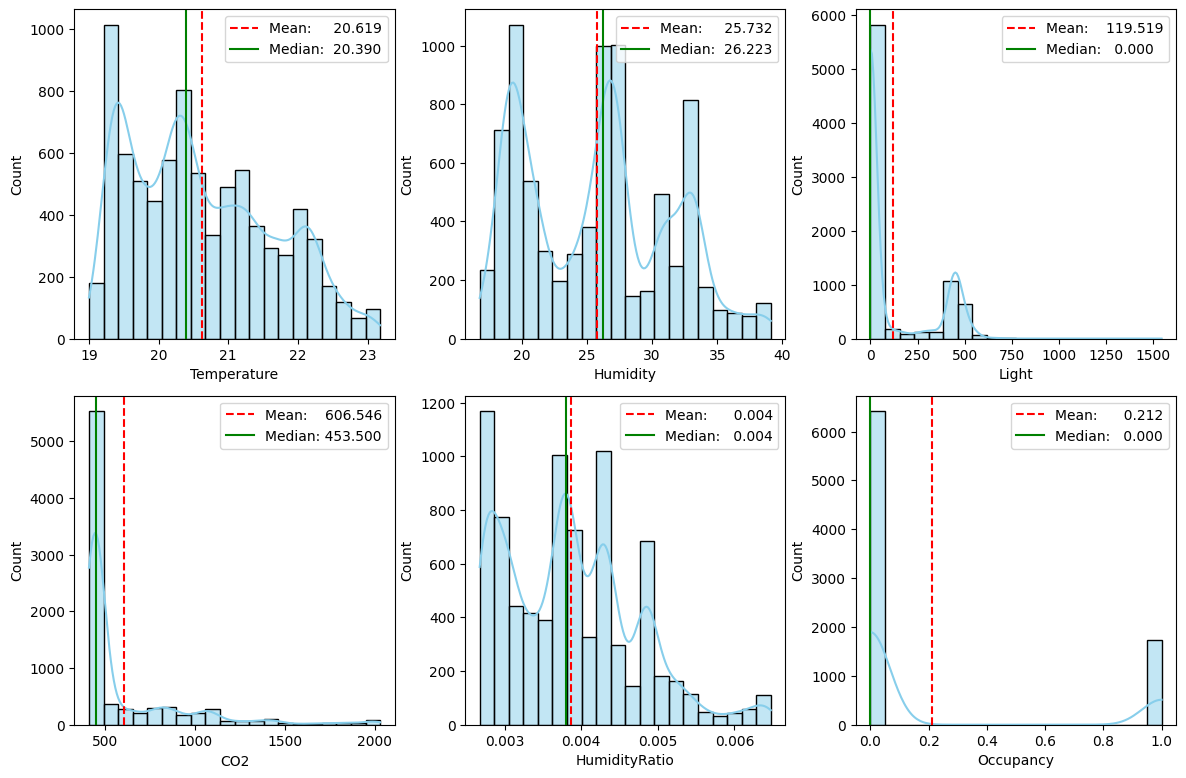

In [4]:
# Базовая описательная статистика
def descriptive_stats(df):
    # Определение количества столбцов и строк для подграфиков
    num_columns = len(df.select_dtypes(include=[float, int]).columns)
    nrows = 2
    ncols = (num_columns + 1) // 2  # чтобы учесть нечетное количество графиков

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
    fig.tight_layout(pad=2.0)
    
    # Преобразуем массив осей для удобного перебора
    axes = axes.flatten()
    
    for i, column in enumerate(df.select_dtypes(include=[float, int]).columns):
        # Среднее и медиана
        mean_val = df[column].mean()
        median_val = df[column].median()

        # Построение гистограммы с KDE
        sns.histplot(df[column], kde=True, ax=axes[i], color="skyblue", edgecolor="black", bins=20)
        
        # Добавляем линии для среднего и медианы
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'{"Mean:":<7}{mean_val:>9.3f}')
        axes[i].axvline(median_val, color='green', linestyle='-', label=f'{"Median:":<7}{median_val:>8.3f}')
        
        # Настройка заголовка и легенды
        # axes[i].set_title(f'{column}', fontsize=10)
        axes[i].legend(loc='upper right')
    
    # Удаляем пустые подграфики, если признаков нечетное количество
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

descriptive_stats(df)

Note: так как значения имеют довольно большой разброс в значениях, то их стоит нормализовать, чтобы хорошо отобразить boxplot. Я сделал concat, чтобы удобно было посмотреть реальные значения в одном месте.

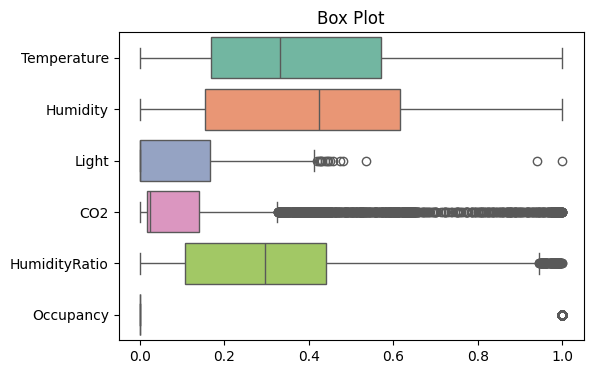

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,0.387341,0.401676,0.077292,0.119942,0.312576,0.212330,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,0.243281,0.247233,0.125947,0.194536,0.224186,0.408982,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,0.167464,0.154431,0.000000,0.016246,0.106304,0.000000,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,0.332536,0.423623,0.000000,0.025220,0.296338,0.000000,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,0.571770,0.616307,0.165795,0.139925,0.441308,0.000000,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [5]:
min_max_scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[df.select_dtypes(include=[float, int]).columns] = min_max_scaler.fit_transform(df.select_dtypes(include=[float, int]))

# Диаграмма размаха (box plot)
plt.figure(figsize=(6, 4))
plt.title('Box Plot for Features')
sns.boxplot(df_normalized, orient="h", palette="Set2")
plt.title(f'Box Plot')
plt.show()

pd.concat([df_normalized.describe(), df.describe()], axis=1)

Интереса ради: видно, что $CO_2$ имеет много выбросов. Попробуем оценить, в какой момент это происходит.
Так как я не разбираюсь в значениях $CO_2$, то уточнил у GPT:

Концентрация углекислого газа (CO₂) в помещении варьируется в зависимости от вентиляции и количества людей. Общепринятые нормы и рекомендации:

    400–500 ppm: Это обычный уровень CO₂ на открытом воздухе.
    600–1000 ppm: Комфортный и безопасный уровень для большинства внутренних помещений с хорошей вентиляцией.
    1000–1500 ppm: Начинается ощущение "затхлости", возможен легкий дискомфорт. Этот уровень допустим, но уже сигнализирует о необходимости улучшения вентиляции.
    1500–2000 ppm: Может вызвать ощущение усталости, снижение концентрации и легкий дискомфорт. Желательно избегать таких значений в жилых или рабочих зонах.
    Выше 2000 ppm: Высокий уровень CO₂, который может вызвать головную боль, сонливость и ухудшение концентрации. Это значение указывает на необходимость срочного улучшения вентиляции.


In [147]:
# Пороговые значения для определения выбросов
Q1 = df_normalized["CO2"].quantile(0.25)
Q3 = df_normalized["CO2"].quantile(0.75)
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтрация строк с выбросами по CO2
outliers_df = df_normalized[(df_normalized["CO2"] < lower_bound) | (df_normalized["CO2"] > upper_bound)]
outliers_df.resample('d').count()


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-05,412,412,412,412,412,412
2015-02-06,16,16,16,16,16,16
2015-02-07,0,0,0,0,0,0
2015-02-08,0,0,0,0,0,0
2015-02-09,635,635,635,635,635,635


Видно, что есть 2 дня с выбросами. Можно сделать выборку по ним и посмотреть другие данные. Может, они тоже завышены.

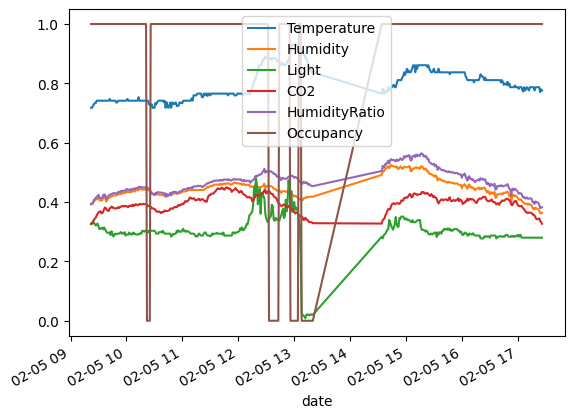

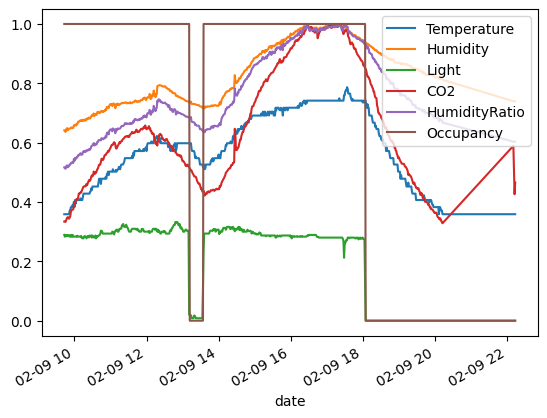

In [153]:
for i, group in outliers_df.resample('d'):
    if i in [pd.Timestamp('2015-02-05'), pd.Timestamp('2015-02-09')]:
        group.plot()

На первом графике температура выше среднего, а на втором почти каждый параметр достиг своего пика. Возможно, это дало какой-то эффект для $CO_2$.
В целом, я бы не говорил, что это какие-то выбросы, если мы не изучаем и не предсказываем погодные условия.

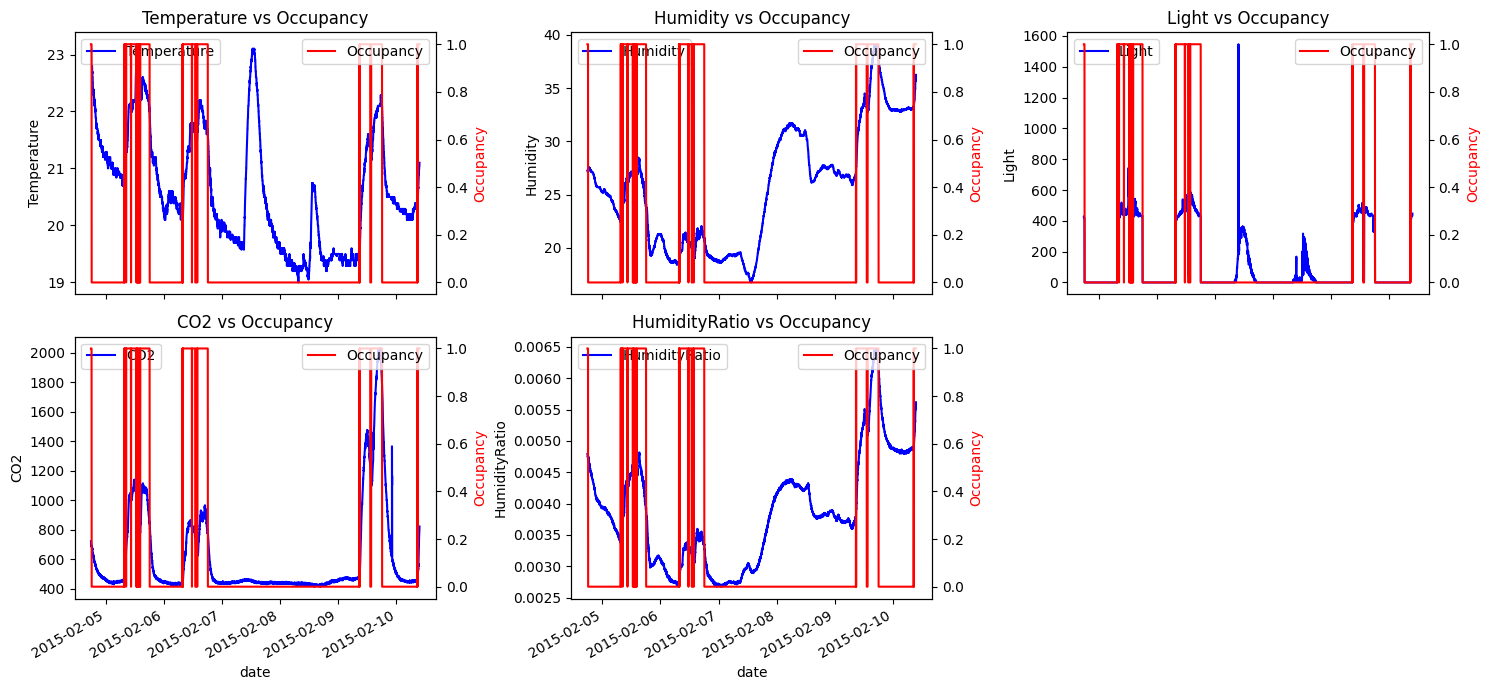

In [154]:
num_columns = len(df.columns[:-1])
ncols = 3
nrows = (num_columns + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 7), sharex=True)
axes = axes.flatten()

for i, column in enumerate(df.columns[:-1]):
    ax = axes[i]
    df[column].plot(ax=ax, color='blue', label=column)
    ax.set_title(f'{column} vs Occupancy')
    ax.set_ylabel(column)
    
    ax_occ = ax.twinx()
    df['Occupancy'].plot(ax=ax_occ, color='red', label='Occupancy')
    ax_occ.set_ylabel('Occupancy', color='red')
    
    ax.legend(loc='upper left')
    ax_occ.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Графики зависимости наличия людей в комнате от других параметров. Видно, что 7-8 февраля были выходными.

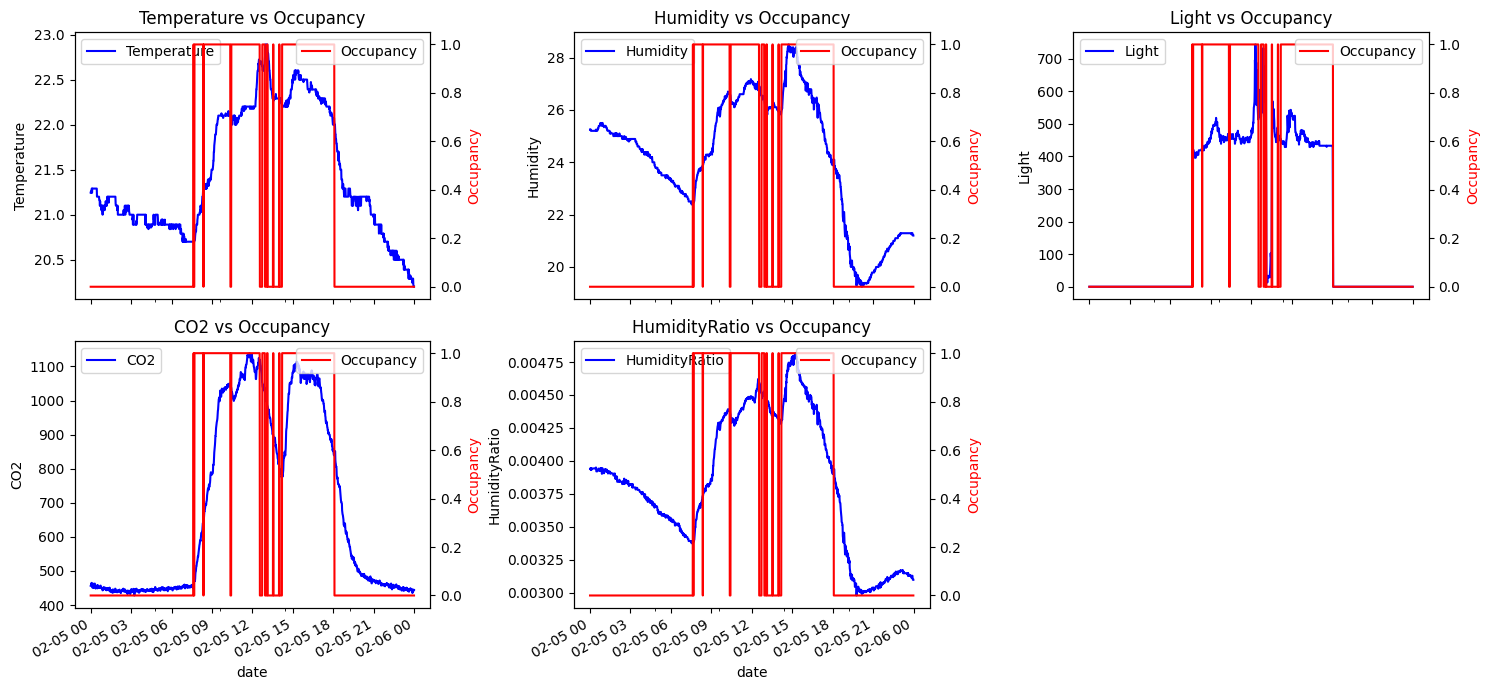

In [6]:
num_columns = len(df.columns[:-1])
ncols = 3
nrows = (num_columns + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 7), sharex=True)
axes = axes.flatten()

for i, column in enumerate(df.columns[:-1]):
    ax = axes[i]
    df[column][369:24*60+369].plot(ax=ax, color='blue', label=column)
    ax.set_title(f'{column} vs Occupancy')
    ax.set_ylabel(column)
    
    ax_occ = ax.twinx()
    df['Occupancy'][369:24*60+369].plot(ax=ax_occ, color='red', label='Occupancy')
    ax_occ.set_ylabel('Occupancy', color='red')
    
    ax.legend(loc='upper left')
    ax_occ.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

На данном графике изображены данные относительно наличия людей в помещении в течение дня.

Легко заметить:
1. Рабочий день с 09:00 до 18:00
2. Любой параметр становится больше как раз с начала рабочего дня

In [17]:
data = df.copy()
data.Occupancy = data.Occupancy.astype(str)
fig = px.scatter_3d(data, x='Temperature', y='Humidity', z='CO2', size='Light', color='Occupancy', color_discrete_map={'1':'red', '0':'blue'})
fig.update_layout(scene_zaxis_type="log", title={'text': "Features and Occupancy",
                                                'y':0.9,
                                                'x':0.5,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

### 2. Работа с пропусками

In [7]:
# Работа с пропусками
print("\nMissing values before handling:")
print(df.isna().sum())
df.fillna(df.median(), inplace=True)
print("\nMissing values after handling:")
print(df.isna().sum())


Missing values before handling:
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

Missing values after handling:
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64


### 3. Работа с дублирующими данными

In [8]:
# Работа с дублирующими данными
duplicates = df.reset_index().duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
df.drop_duplicates(inplace=True)


Number of duplicate rows: 0


### 4. Работа с выбросами

In [21]:
# Работа с выбросами (Используем IQR для выявления выбросов)
def remove_outliers(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        mask = (df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))
        df = df[mask]
    return df

df_not_outliers = remove_outliers(df)
df_not_outliers.Occupancy.unique()

array([0], dtype=int64)

Выбросы - это люди в помещении. Интересная ситуация.

### 5. Проведение статистических тестов, построение коррелограммы и иные исследования на временные лаги


--- Анализ параметра: Temperature ---


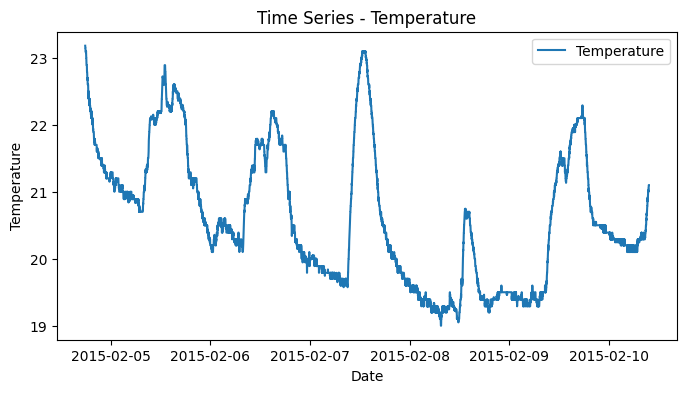

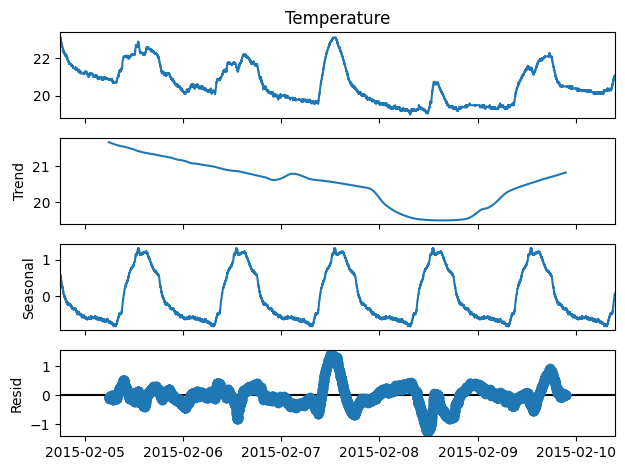

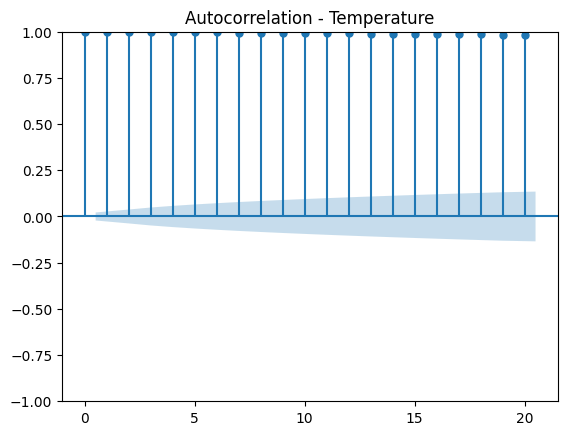

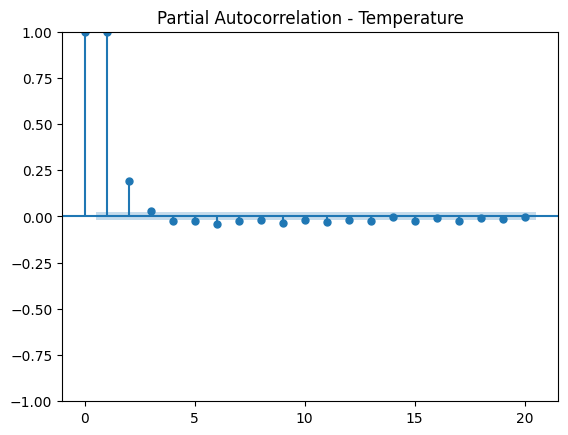

+----------------------------+------------+
| Метрика                    |   Значение |
+============================+============+
| ADF Statistic              | -2.69443   |
+----------------------------+------------+
| p-значение                 |  0.0750064 |
+----------------------------+------------+
| Критическое значение (1%)  | -3.43116   |
+----------------------------+------------+
| Критическое значение (5%)  | -2.8619    |
+----------------------------+------------+
| Критическое значение (10%) | -2.56696   |
+----------------------------+------------+


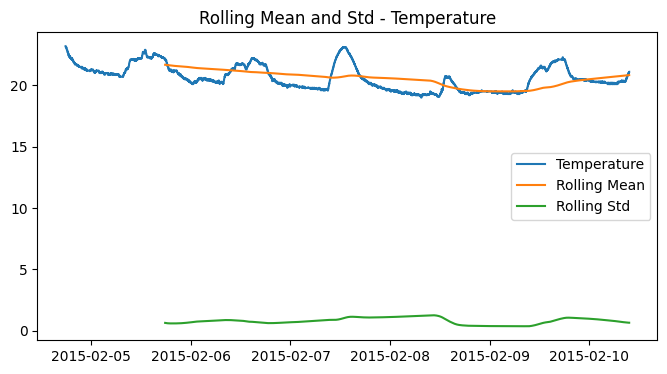

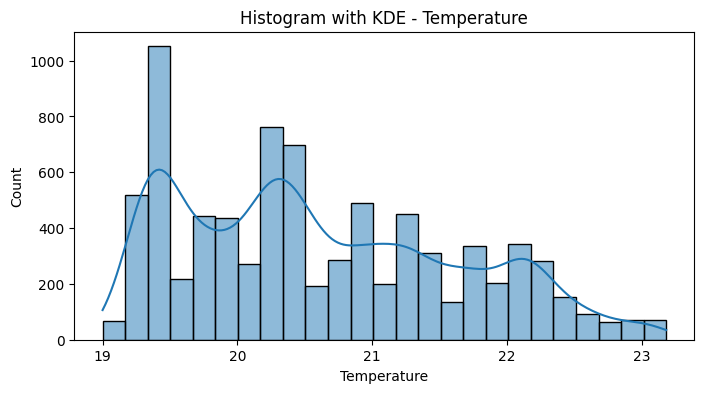

+-----------------------------+----------------+
| Метрика                     |       Значение |
+=============================+================+
| Скошенность                 |   0.450785     |
+-----------------------------+----------------+
| Эксцесс                     |  -0.810482     |
+-----------------------------+----------------+
| Статистика теста Д’Агостино | 975.745        |
+-----------------------------+----------------+
| p-значение                  |   1.31723e-212 |
+-----------------------------+----------------+

--- Анализ параметра: Humidity ---


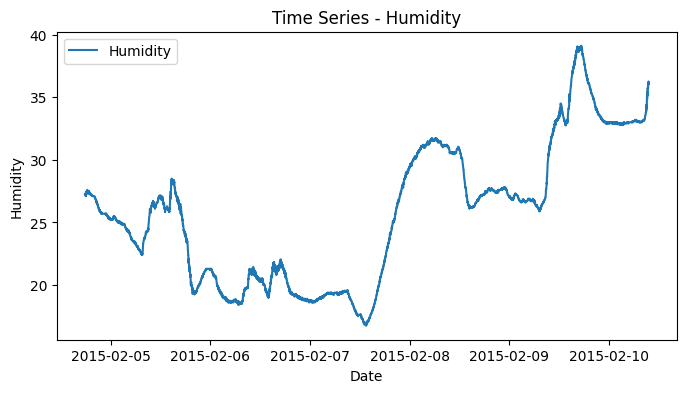

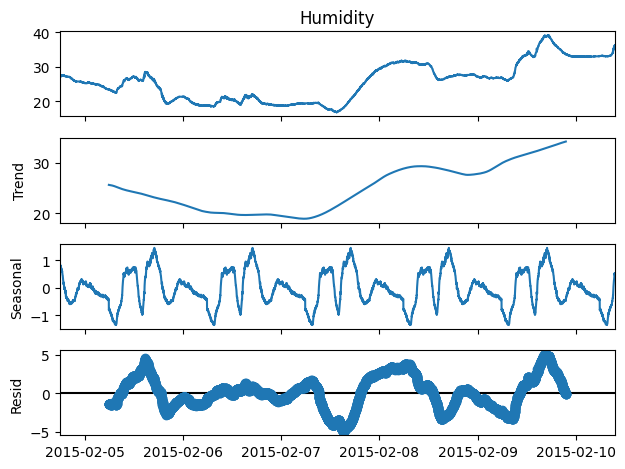

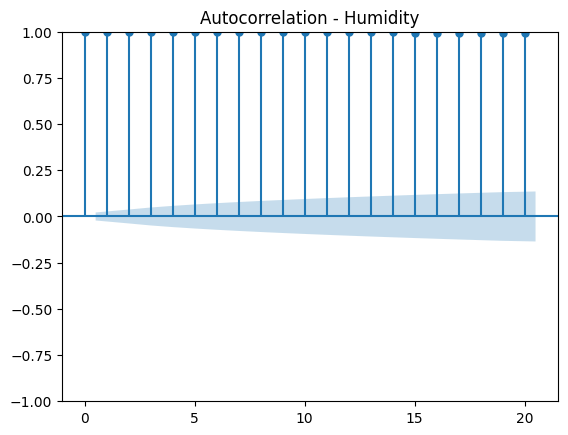

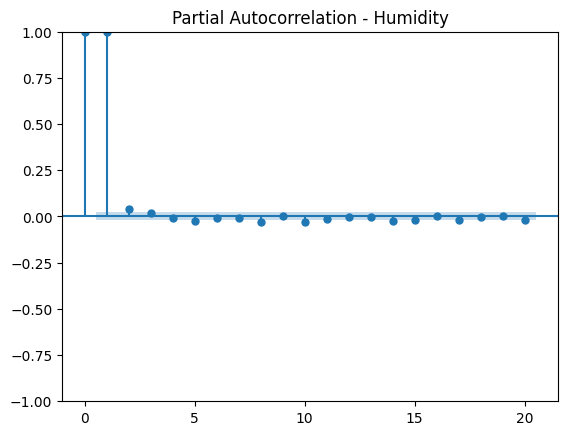

+----------------------------+------------+
| Метрика                    |   Значение |
+============================+============+
| ADF Statistic              |  -0.751632 |
+----------------------------+------------+
| p-значение                 |   0.832919 |
+----------------------------+------------+
| Критическое значение (1%)  |  -3.43116  |
+----------------------------+------------+
| Критическое значение (5%)  |  -2.8619   |
+----------------------------+------------+
| Критическое значение (10%) |  -2.56696  |
+----------------------------+------------+


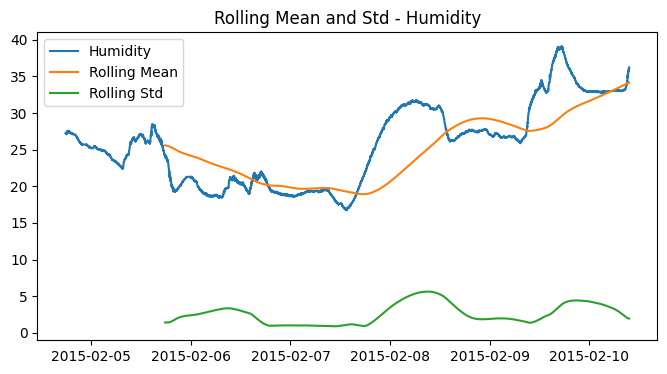

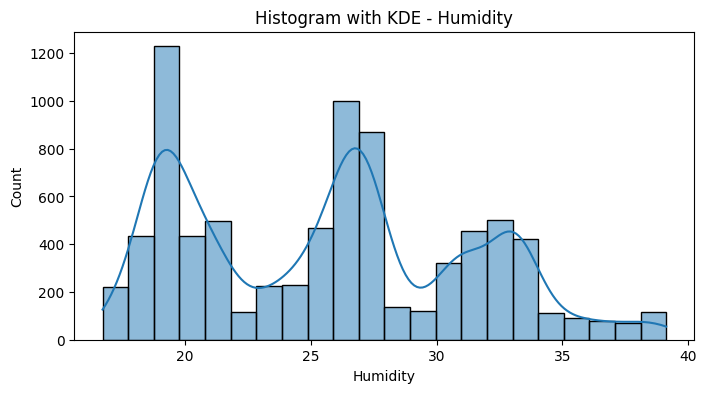

+-----------------------------+-----------------+
| Метрика                     |        Значение |
+=============================+=================+
| Скошенность                 |    0.271968     |
+-----------------------------+-----------------+
| Эксцесс                     |   -0.932045     |
+-----------------------------+-----------------+
| Статистика теста Д’Агостино | 1401.89         |
+-----------------------------+-----------------+
| p-значение                  |    3.82292e-305 |
+-----------------------------+-----------------+

--- Анализ параметра: Light ---


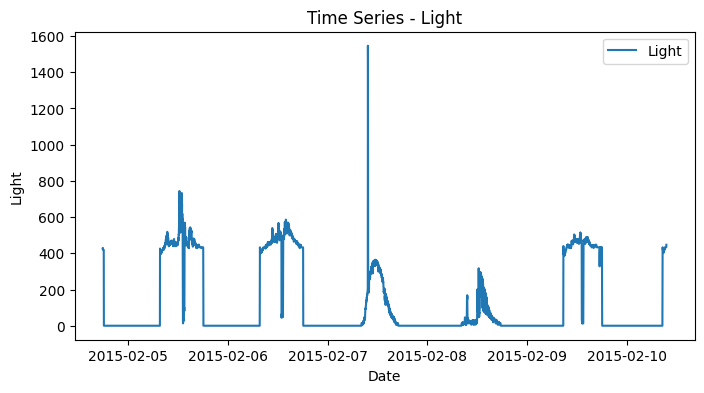

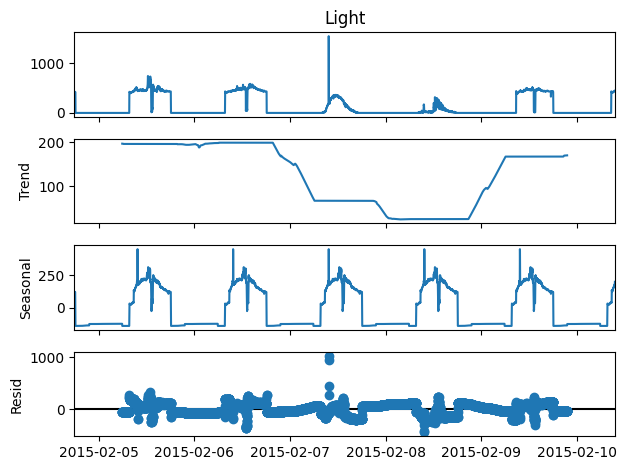

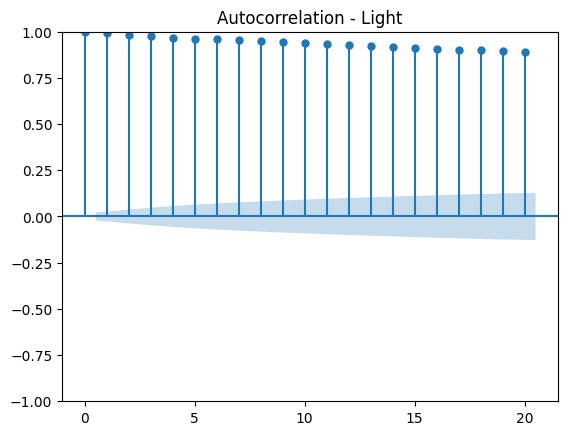

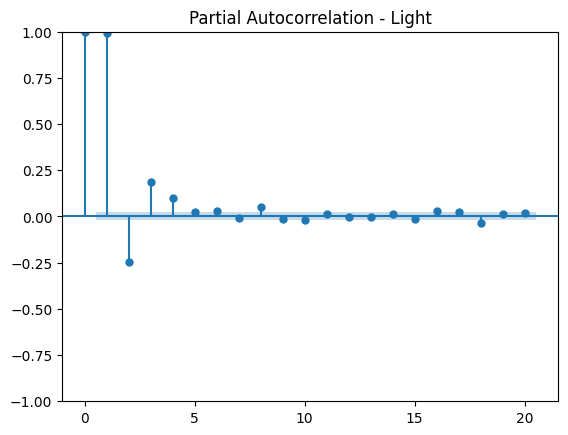

+----------------------------+------------+
| Метрика                    |   Значение |
+============================+============+
| ADF Statistic              | -3.31465   |
+----------------------------+------------+
| p-значение                 |  0.0142362 |
+----------------------------+------------+
| Критическое значение (1%)  | -3.43116   |
+----------------------------+------------+
| Критическое значение (5%)  | -2.8619    |
+----------------------------+------------+
| Критическое значение (10%) | -2.56696   |
+----------------------------+------------+


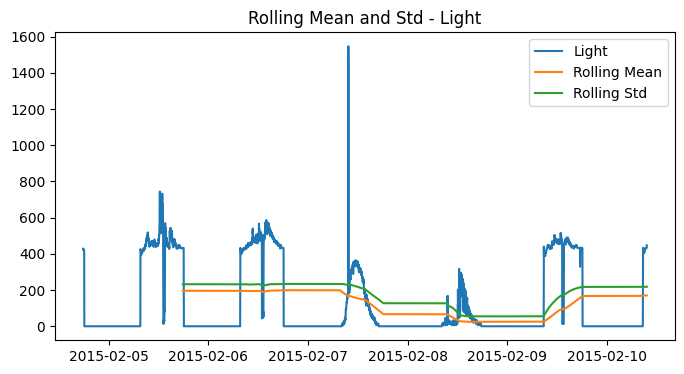

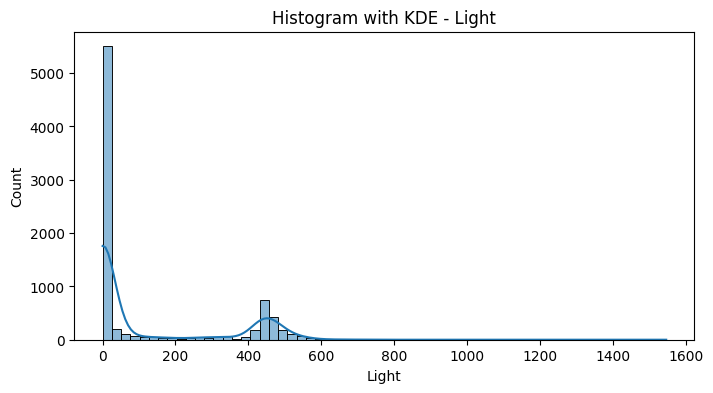

+-----------------------------+-----------------+
| Метрика                     |        Значение |
+=============================+=================+
| Скошенность                 |    1.23721      |
+-----------------------------+-----------------+
| Эксцесс                     |    0.12234      |
+-----------------------------+-----------------+
| Статистика теста Д’Агостино | 1318.06         |
+-----------------------------+-----------------+
| p-значение                  |    6.10693e-287 |
+-----------------------------+-----------------+

--- Анализ параметра: CO2 ---


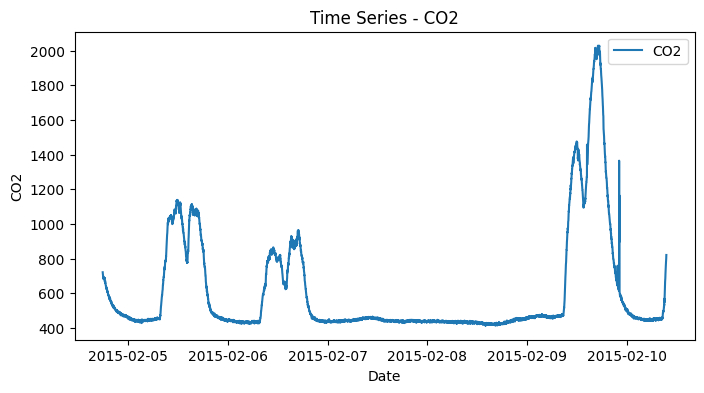

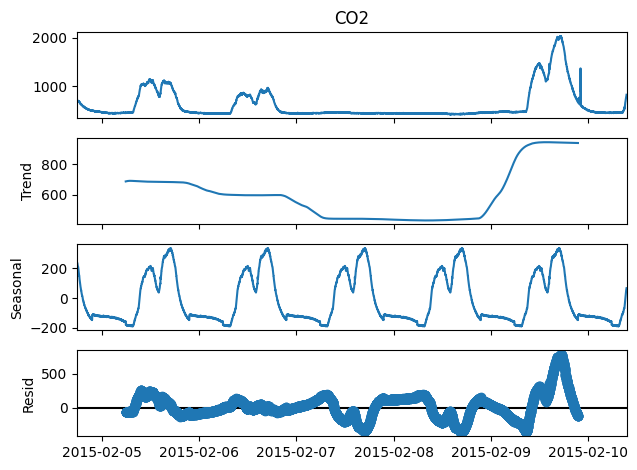

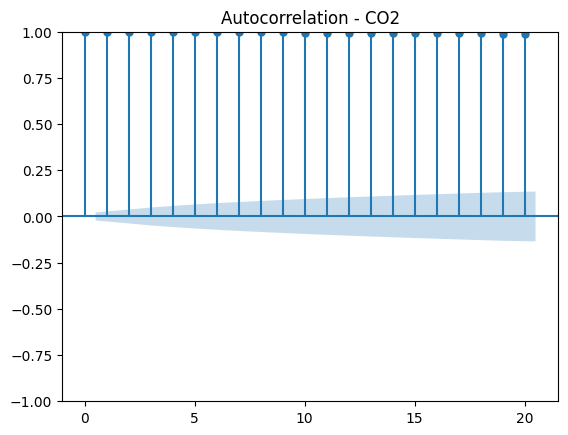

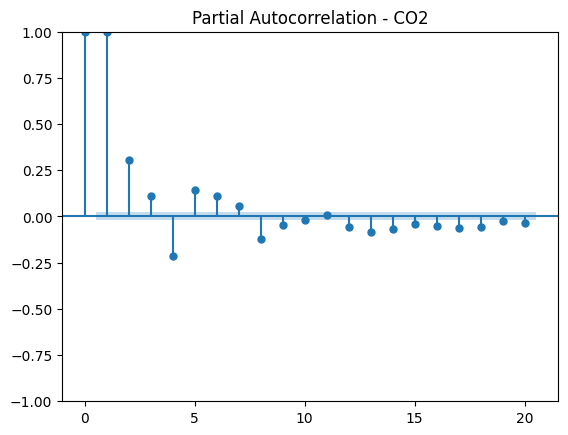

+----------------------------+-------------+
| Метрика                    |    Значение |
+============================+=============+
| ADF Statistic              | -3.639      |
+----------------------------+-------------+
| p-значение                 |  0.00505769 |
+----------------------------+-------------+
| Критическое значение (1%)  | -3.43116    |
+----------------------------+-------------+
| Критическое значение (5%)  | -2.8619     |
+----------------------------+-------------+
| Критическое значение (10%) | -2.56696    |
+----------------------------+-------------+


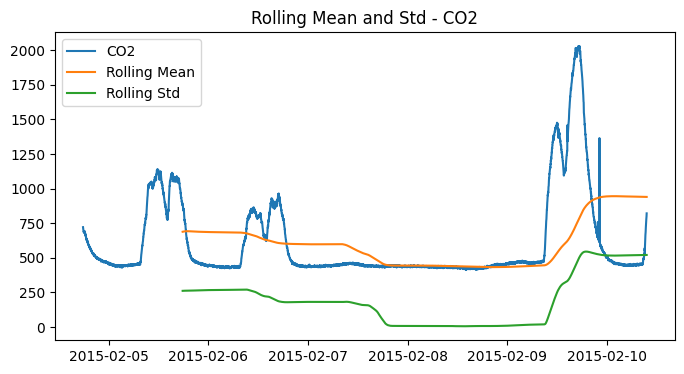

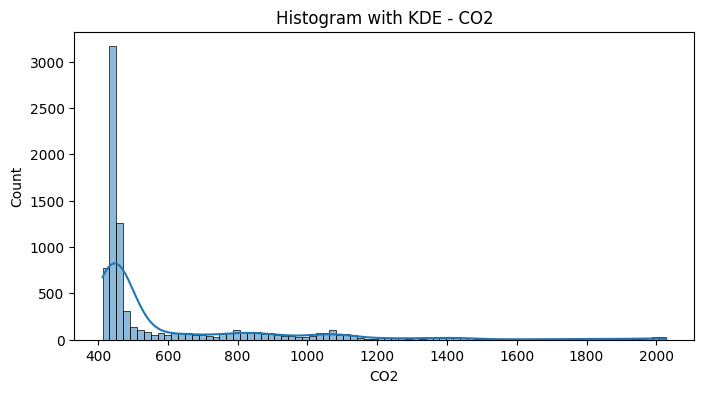

+-----------------------------+------------+
| Метрика                     |   Значение |
+=============================+============+
| Скошенность                 |    2.38047 |
+-----------------------------+------------+
| Эксцесс                     |    5.77113 |
+-----------------------------+------------+
| Статистика теста Д’Агостино | 3913.53    |
+-----------------------------+------------+
| p-значение                  |    0       |
+-----------------------------+------------+

--- Анализ параметра: HumidityRatio ---


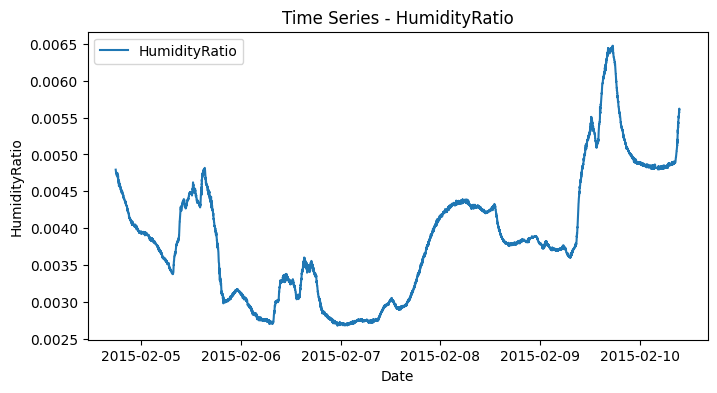

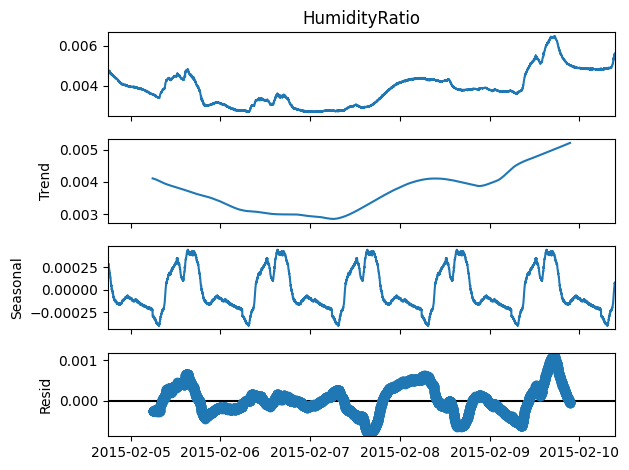

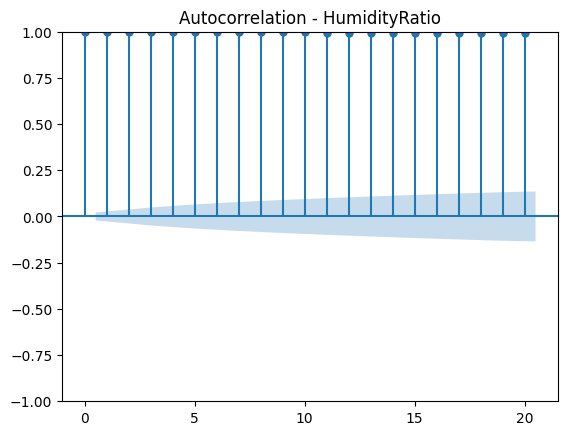

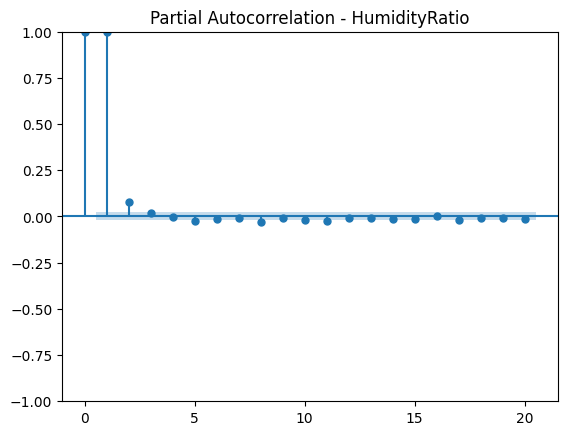

+----------------------------+------------+
| Метрика                    |   Значение |
+============================+============+
| ADF Statistic              |  -1.27971  |
+----------------------------+------------+
| p-значение                 |   0.638403 |
+----------------------------+------------+
| Критическое значение (1%)  |  -3.43116  |
+----------------------------+------------+
| Критическое значение (5%)  |  -2.8619   |
+----------------------------+------------+
| Критическое значение (10%) |  -2.56696  |
+----------------------------+------------+


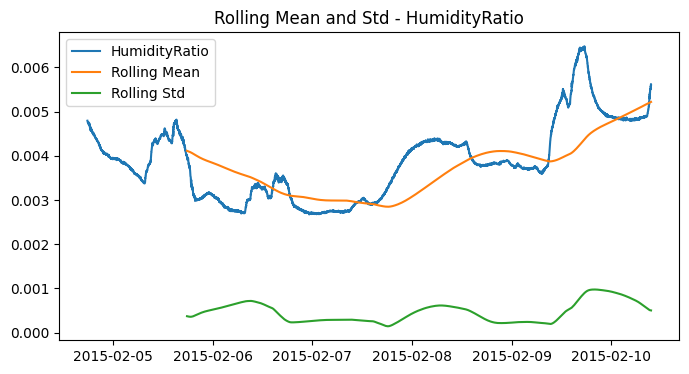

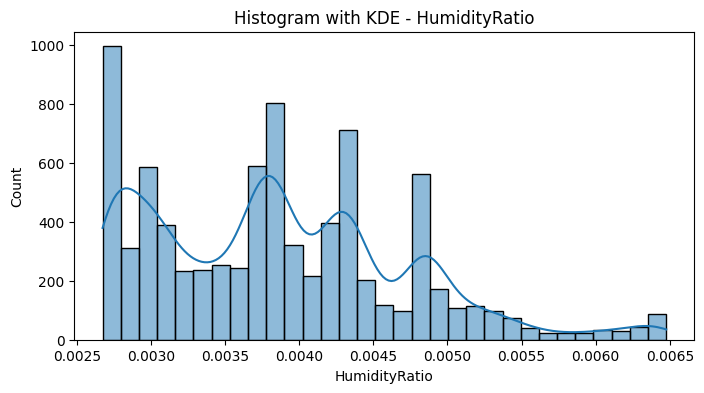

+-----------------------------+---------------+
| Метрика                     |      Значение |
+=============================+===============+
| Скошенность                 |   0.616568    |
+-----------------------------+---------------+
| Эксцесс                     |   0.0385944   |
+-----------------------------+---------------+
| Статистика теста Д’Агостино | 441.388       |
+-----------------------------+---------------+
| p-значение                  |   1.42521e-96 |
+-----------------------------+---------------+


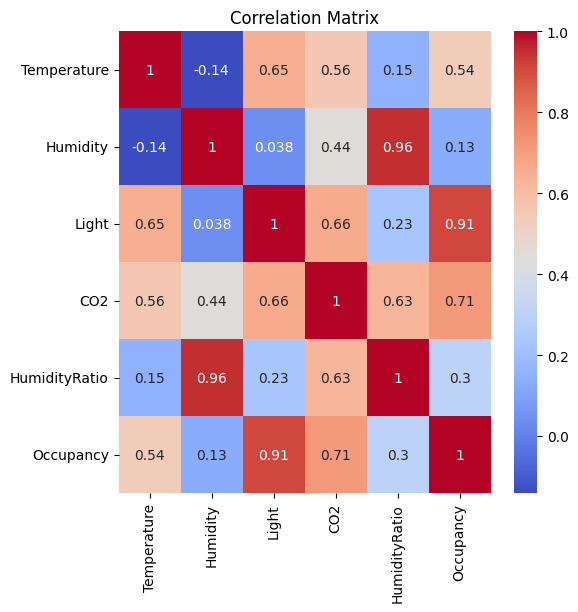

In [26]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import kurtosis, skew, shapiro, normaltest
from statsmodels.stats.diagnostic import het_goldfeldquandt


# Список параметров для анализа
parameters = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

# Функция для отрисовки всех визуализаций и тестов для каждого параметра
def analyze_parameter(df, param):
    print(f"\n--- Анализ параметра: {param} ---")

    # Линейный график для тренда
    plt.figure(figsize=(8, 4))
    plt.plot(df[param], label=param)
    plt.title(f'Time Series - {param}')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.legend()
    plt.show()

    # Декомпозиция временного ряда
    decomposition = sm.tsa.seasonal_decompose(df[param], model='additive', period=1440)
    fig = decomposition.plot()
    plt.show()

    # Автокорреляция и частичная автокорреляция
    sm.graphics.tsa.plot_acf(df[param], lags=20)
    plt.title(f'Autocorrelation - {param}')
    plt.show()

    sm.graphics.tsa.plot_pacf(df[param], lags=20)
    plt.title(f'Partial Autocorrelation - {param}')
    plt.show()

    # Тест на стационарность (Дики-Фуллер)
    # Проведение теста Дики-Фуллера
    result = adfuller(df[param].dropna())
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4] # type: ignore

    # Формирование таблицы для результатов
    table = [
        ["Метрика", "Значение"],
        ["ADF Statistic", adf_stat],
        ["p-значение", p_value],
        ["Критическое значение (1%)", critical_values["1%"]], # type: ignore
        ["Критическое значение (5%)", critical_values["5%"]], # type: ignore
        ["Критическое значение (10%)", critical_values["10%"]]# type: ignore
    ]

    print(tabulate(table, headers="firstrow", tablefmt="grid"))

    # Скользящее среднее и стандартное отклонение
    df[f'{param}_Rolling_Mean'] = df[param].rolling(window=1440).mean()
    df[f'{param}_Rolling_Std'] = df[param].rolling(window=1440).std()

    plt.figure(figsize=(8, 4))
    plt.plot(df[param], label=param)
    plt.plot(df[f'{param}_Rolling_Mean'], label='Rolling Mean')
    plt.plot(df[f'{param}_Rolling_Std'], label='Rolling Std')
    plt.title(f'Rolling Mean and Std - {param}')
    plt.legend()
    plt.show()

    # Гистограмма и график плотности (KDE)
    plt.figure(figsize=(8, 4))
    sns.histplot(df[param], kde=True)
    plt.title(f'Histogram with KDE - {param}')
    plt.show()

    # Скошенность и эксцесс
    skewness = skew(df[param].dropna())
    kurt = kurtosis(df[param].dropna())

    # Тесты на нормальность
    # Тест Д’Агостино
    stat, p = normaltest(df[param].dropna())

    table = [
    ["Метрика", "Значение"],
    ["Скошенность", skewness],
    ["Эксцесс", kurt],
    ["Статистика теста Д’Агостино", stat],
    ["p-значение", p]
    ]

    print(tabulate(table, headers="firstrow", tablefmt="grid"))


for param in parameters:
    analyze_parameter(df, param)

df = pd.read_csv('data/datatraining.txt', parse_dates=['date'])
df.set_index('date', inplace=True)

# Матрица корреляций и тепловая карта для всех переменных
plt.figure(figsize=(6, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

* Тест Д’Агостино показал, что данные не имеет нормального распределения.
* Тест Дики-Фуллера показал, что некоторые данные стационарны.
* По матрице корреляций видно, что свет, значения $CO_2$ и температура имеют влияние.

### 6. Спектральный анализ (выявление колебаний и их частот)

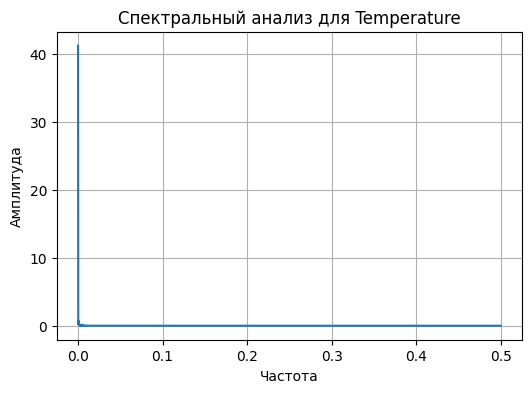

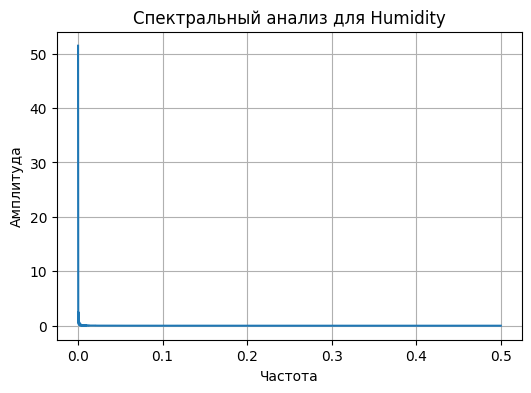

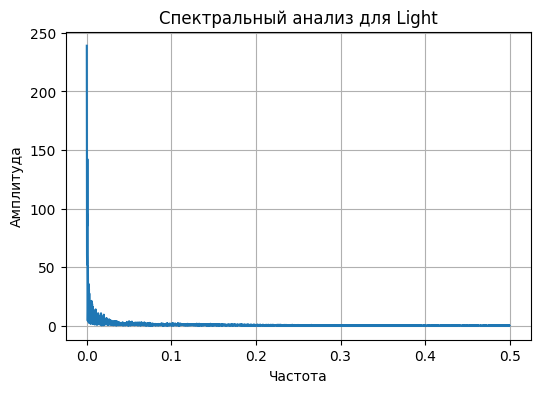

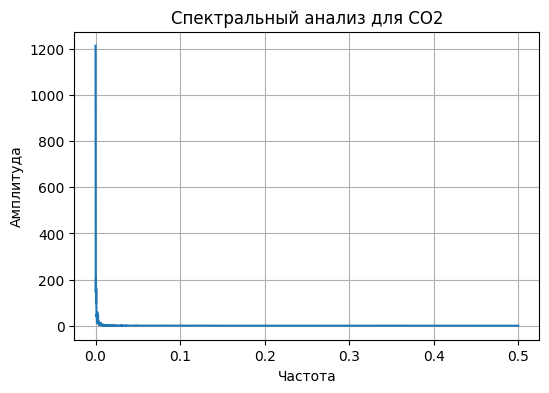

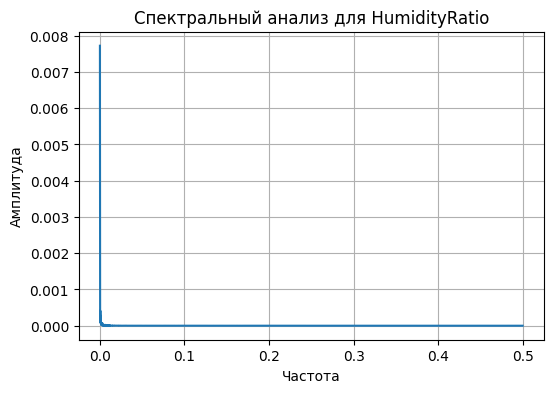

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

for param in parameters:
    # Заданный временной ряд
    data = df[param].dropna().values  # Преобразуем Series в numpy array

    # Определение частоты дискретизации
    n = len(data)                 # Количество точек
    T = 1  # Шаг по времени (1 минута)

    # Применение FFT и получение частот
    yf = fft(data)                # Результат FFT
    xf = fftfreq(n, T)[:n // 2]   # Частоты, соответствующие компонентам

    plt.figure(figsize=(6, 4))
    plt.plot(xf, 2.0 / n * np.abs(yf[:n // 2]))
    plt.xlabel('Частота')
    plt.ylabel('Амплитуда')
    plt.title(f'Спектральный анализ для {param}')
    plt.grid()
    plt.show()

Здесь я ничего не могу сказать.

### 7. работа с категориальными данными

Таких данных не оказалось

### 8. Анализ зависимостей между признаками

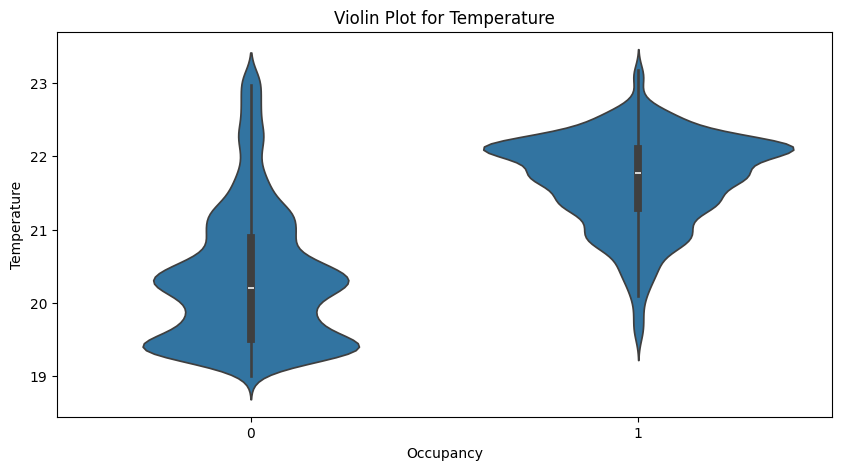

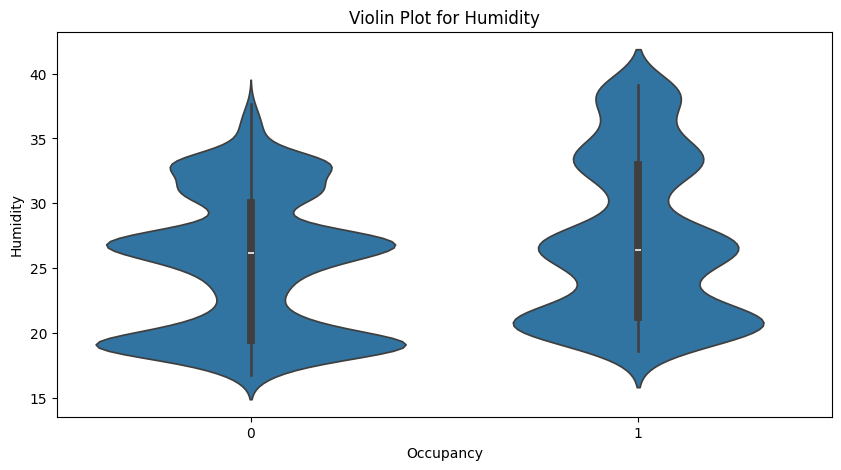

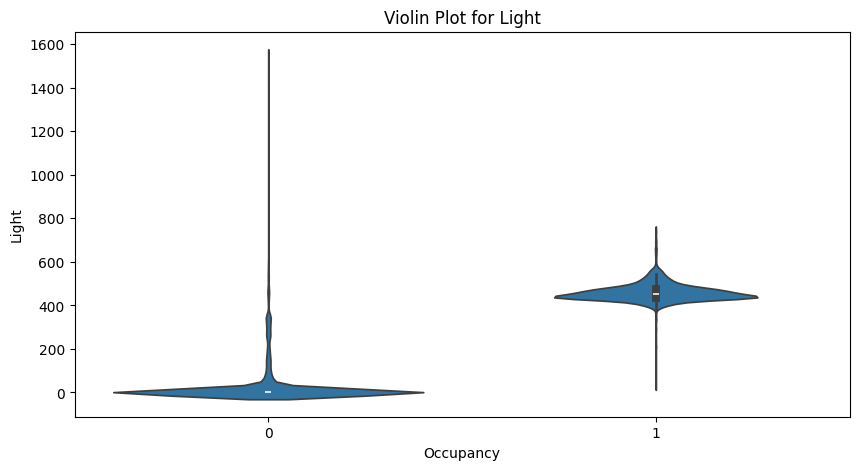

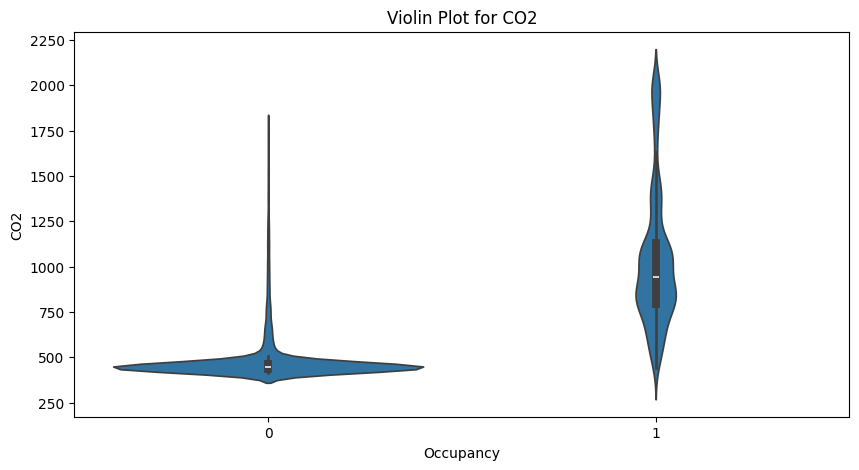

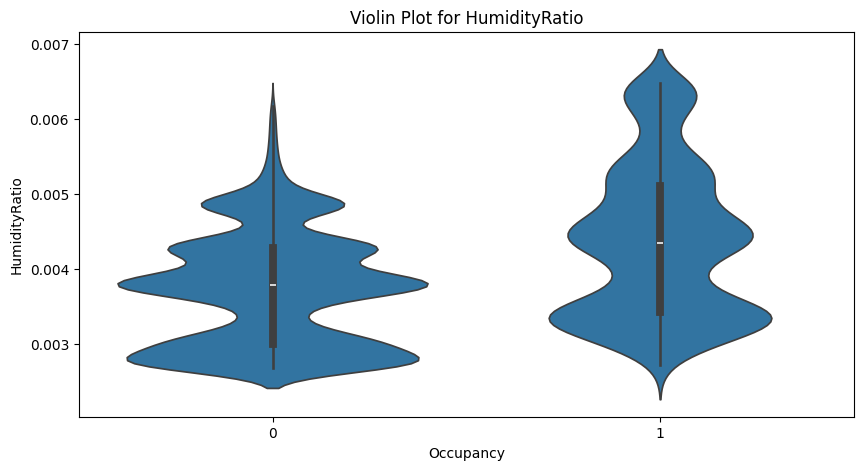

In [22]:
# Скрипичные диаграммы для распределения данных по переменным
for column in parameters:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x='Occupancy', y=column, data=df)
    plt.title(f'Violin Plot for {column}')
    plt.show()

По этим данным также как и на plot графиках неплохо видно, когда в помещении кто-то был.

Например:
1. Плотность больше при более высокой температуре. Логично, так как днем теплее (время понятно из прошлых графиков)
2. Свет около 400 единиц, когда кто-то есть. Возможно это лампочки в помещении, возможно, Солнце светит.
3. Значения $CO_2$ выше, когда кто-то есть. Очевидно, надышали.

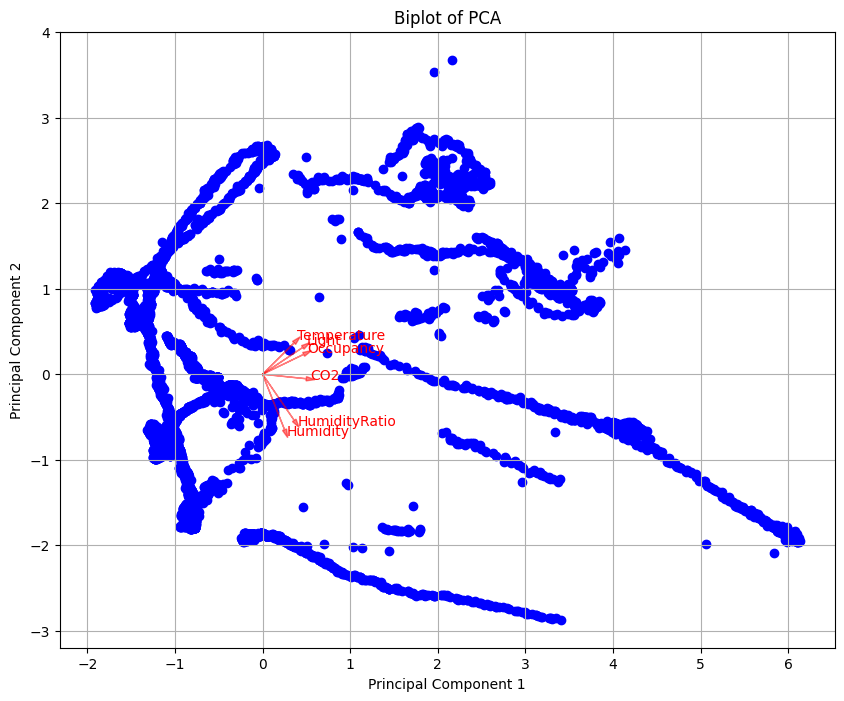

In [23]:
# Стандартизируем данные
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Применяем PCA
pca = PCA(n_components=2)  # Мы выбираем первые 2 компоненты
principal_components = pca.fit_transform(scaled_data)

pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
plt.figure(figsize=(10, 8))
plt.scatter(pc_df['PC1'], pc_df['PC2'], color='blue', label='Observations')

# Стрелки для переменных
for i, column in enumerate(df.columns):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
              color='red', alpha=0.5, head_width=0.05, head_length=0.1)
    plt.text(pca.components_[0, i] * 1.1, pca.components_[1, i] * 1.1, column, color='red')

plt.title('Biplot of PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

В целом, как я написал выше, наличие человека можно определить по температуре и наличии света. Эти данные хорошо коррелируют между собой.